# **Project Milestone 2**
# Topic: CNC Machining
# Group #72

[Link to Data source](https://github.com/boschresearch/CNC_Machining/tree/main)

## **About the data**:

The data is the 3 axis accelerometer reading captured off of CNC milling machines as they are working on 14 different pieces. The milling machines are typically the centerpiece in metalworking workshops and factories as it is a versatile tool capable of performing a wide range of actions using a number of tools available to it. Down time of the CNC machine in a metal working facility can affect the overall productivity of a production facility.


By capturing the accelerometer readings in all 3 axes, the researchers are hoping to detect defects as early as possible, and accordingly reduce the time wasted by the machine in working on a defective part. To ensure that the machine learning solution is able to generalize, the researchers provided the sensor readings from 3 different machines, each working on 14 different operations. In total, we have 1.7K operations, 70 of which produced bad results.


The data consists of arrays of varying sizes for each operation. The sensor captures the readings at a rate of 2000 readings/sec. Looking at the duration of the operations, we see that the operation lasts between **13.4 Seconds and 158.7 seconds** and the acceleration readings for all 3 axes are typically between **636 and 6552**. Since the data is a sensor reading time series without a timestamp, It is assumed that the readings are consecutive and no missing data concerns. looking at the data, we see that there are no "0" values which might indicate that the sensor had an issue reporting the data.


Since each operation has a different duration, each sample has a different input size. One approach is to standardize the input size to ensure that we are feeding our network the same data every time. The other approach is to use a much smaller moving window, thus giving the model the ability to review operations with any duration. This model design choice will be taken in the next milestone.


Another challenge that the team will face is the extreme imbalance between the successful operations "good" where we have 1630 samples, and the unsuccessful "bad" operations where we have 70 samples. To tackle this imbalance, the team is considering using models that could help with anomaly detection, such as autoencoders. The team is also considering exploring the use of RNN/LSTM for dealing with the time series (AT the point of writing this review, the professor has not explained RNN and LSTM yet). The exact design choice will be handled in milestone 3.


Since Frequency plays a key part in this sensor data, the team will attempt using fourier transformation to try to extract frequency changes and trends in the data. An additional feature that might be helpful in this exercise is calculating the rate of change of acceleration, the "jerk" to uncover sudden movement caused by tool breakage or other unexpected changes in the operation.






In [1]:
!pip install gdown
import gdown

file_id = "1NpVQmQlylyOr0JvK74_baBCQa4daxs8b"
destination = "CNC_Machining_main.zip" 

# gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)
!gdown --fuzzy "https://drive.google.com/uc?export=download&id=$file_id" -O $destination
!unzip $destination -d /content

Downloading...
From (original): https://drive.google.com/uc?id=1NpVQmQlylyOr0JvK74_baBCQa4daxs8b
From (redirected): https://drive.google.com/uc?id=1NpVQmQlylyOr0JvK74_baBCQa4daxs8b&confirm=t&uuid=64be07c5-fb6e-4542-a90d-08d1e4ccbe37
To: /kaggle/working/CNC_Machining_main.zip
100%|█████████████████████████████████████████| 928M/928M [00:07<00:00, 121MB/s]
Archive:  CNC_Machining_main.zip
  inflating: /content/.gitignore     
   creating: /content/data/M01/
   creating: /content/data/M01/OP00/
   creating: /content/data/M01/OP00/good/
  inflating: /content/data/M01/OP00/good/M01_Aug_2019_OP00_000.h5  
  inflating: /content/data/M01/OP00/good/M01_Aug_2019_OP00_001.h5  
  inflating: /content/data/M01/OP00/good/M01_Aug_2019_OP00_003.h5  
  inflating: /content/data/M01/OP00/good/M01_Aug_2019_OP00_004.h5  
  inflating: /content/data/M01/OP00/good/M01_Aug_2019_OP00_005.h5  
  inflating: /content/data/M01/OP00/good/M01_Aug_2019_OP00_006.h5  
  inflating: /content/data/M01/OP00/good/M01_Aug_2019

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import sys
import numpy as np
from pathlib import Path
import itertools
from collections import Counter
from typing import Literal
from scipy.signal import stft
from contextlib import redirect_stdout
from io import StringIO

## Helper functions from original research group

In [3]:
def find_all_h5s_in_dir(s_dir: os.PathLike):
    """
    list all .h5 files in a directory
    """

    fileslist = []
    for root, dirs, files in os.walk(s_dir):
        for file in files:
            if file.endswith(".h5"):
                fileslist.append(file)
    return fileslist


def load_tool_research_data(data_path: os.PathLike, label: Literal["good","bad"], add_additional_label: bool =True, verbose: bool =True):
    """
    load data (good and bad) from the research data storages
    
    Keyword Arguments:
            data_path {str} -- [path to the directory] 
            label {str} -- ["good" or "bad"]
            add_additional_label {bool} -- [if true the labels will be in the form of "Mxx_Aug20xx_OPxx_sampleNr_label" otherwise "label"] (default: True)
            verbose {bool}

        Returns:
            datalist --  [list of the the X samples]
            label --  [list of the the y labels ]
    """
    datalist = []
    data_label = []

    # list all .h5 files
    list_paths = find_all_h5s_in_dir(data_path)
    list_paths.sort()
    if not list_paths and verbose:
        print(f"skipping {data_path} empty directory...")

    # read and append the samples with the corresponding labels
    if verbose:
        print(f"loading files from {data_path}... ")
    for element in list_paths:
        # check if additional label needed ("Mxx_Aug20xx_Tool,nrX") 
        if add_additional_label:
            add_label = element.split('/')[-1]
            additional_label = add_label[:-3] + "_" + label
        else:
            additional_label = label
        # extract data X and y 
        with h5py.File(os.path.join(data_path, element), 'r') as f:
            vibration_data = f['vibration_data'][:]
        datalist.append(vibration_data)
        data_label.append(additional_label)

    return datalist, data_label


def datafile_read(file: os.PathLike, plotting=True):
    """loads and plots the data from the datafile

    Keyword Arguments:
        file {str} -- [path of the file] 

    Returns:
        ndarray --  [raw data original]
    """
    with h5py.File(file, 'r') as f:
        vibration_data = f['vibration_data'][:]
    # interpolation for x axis plot
    freq = 2000
    samples_s = len(vibration_data[:, 0]) / freq
    samples = np.linspace(0, samples_s, len(vibration_data[:, 0]))

    # plotting
    if plotting:
        plt.figure(figsize=(20, 5))
        plt.plot(samples, vibration_data[:, 0], 'b')
        plt.ylabel('X-axis Vibration Data')
        plt.xlabel('Time [sec]')
        plt.locator_params(axis='y', nbins=10)
        plt.grid()
        plt.show()
        plt.figure(figsize=(20, 5))
        plt.plot(samples, vibration_data[:, 1], 'b')
        plt.ylabel('Y-axis Vibration Data')
        plt.xlabel('Time [sec]')
        plt.locator_params(axis='y', nbins=10)
        plt.grid()
        plt.show()
        plt.figure(figsize=(20, 5))
        plt.plot(samples, vibration_data[:, 2], 'b')
        plt.ylabel('Z-axis Vibration Data')
        plt.xlabel('Time [sec]')
        plt.locator_params(axis='y', nbins=10)
        plt.grid()
        plt.show()
    return vibration_data

In [4]:
machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]
path_to_dataset = Path("./data/CNC_Machining-main").absolute()

In [5]:
X_data = []
y_data = []

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    data_list, data_label = load_tool_research_data(data_path, label=label)
    #concatenating
    X_data.extend(data_list)
    y_data.extend(data_label)

skipping /kaggle/working/data/CNC_Machining-main/M01/OP00/good empty directory...
loading files from /kaggle/working/data/CNC_Machining-main/M01/OP00/good... 
skipping /kaggle/working/data/CNC_Machining-main/M01/OP00/bad empty directory...
loading files from /kaggle/working/data/CNC_Machining-main/M01/OP00/bad... 
skipping /kaggle/working/data/CNC_Machining-main/M02/OP00/good empty directory...
loading files from /kaggle/working/data/CNC_Machining-main/M02/OP00/good... 
skipping /kaggle/working/data/CNC_Machining-main/M02/OP00/bad empty directory...
loading files from /kaggle/working/data/CNC_Machining-main/M02/OP00/bad... 
skipping /kaggle/working/data/CNC_Machining-main/M03/OP00/good empty directory...
loading files from /kaggle/working/data/CNC_Machining-main/M03/OP00/good... 
skipping /kaggle/working/data/CNC_Machining-main/M03/OP00/bad empty directory...
loading files from /kaggle/working/data/CNC_Machining-main/M03/OP00/bad... 
skipping /kaggle/working/data/CNC_Machining-main/M01

## Load and visualize the sensor data

In [6]:
# Add the utils directory to the system path
sys.path.append('/content/utils')

# Import data_loader_utils
# import data_loader_utils

# Define dataset parameters
machines = ["M01", "M02", "M03"]
process_names = ["OP00", "OP01", "OP02", "OP03", "OP04", "OP05", "OP06", "OP07", "OP08", "OP09", "OP10", "OP11", "OP12", "OP13", "OP14"]
labels = ["good", "bad"]
path_to_dataset = Path("/content/data").absolute()

# Initialize lists for data and labels
X_data = []
y_data = []

# Suppress output during loading
with redirect_stdout(StringIO()):
    for process_name, machine, label in itertools.product(process_names, machines, labels):
        data_path = os.path.join(path_to_dataset, machine, process_name, label)
        if not os.path.exists(data_path) or not os.path.isdir(data_path):
            continue

        data_list, data_label = load_tool_research_data(data_path, label=label)
        X_data.extend(data_list)
        y_data.extend(data_label)

# Print only the final results
print(f"Total samples loaded into X_data: {len(X_data)}")
print(f"Total labels loaded into y_data: {len(y_data)}")

Total samples loaded into X_data: 1702
Total labels loaded into y_data: 1702



Duration Range for Good Data (seconds):
  Minimum: 18.43 seconds
  Maximum: 158.72 seconds
  Average: 53.00 seconds

Duration Range for Bad Data (seconds):
  Minimum: 13.40 seconds
  Maximum: 130.00 seconds
  Average: 40.14 seconds


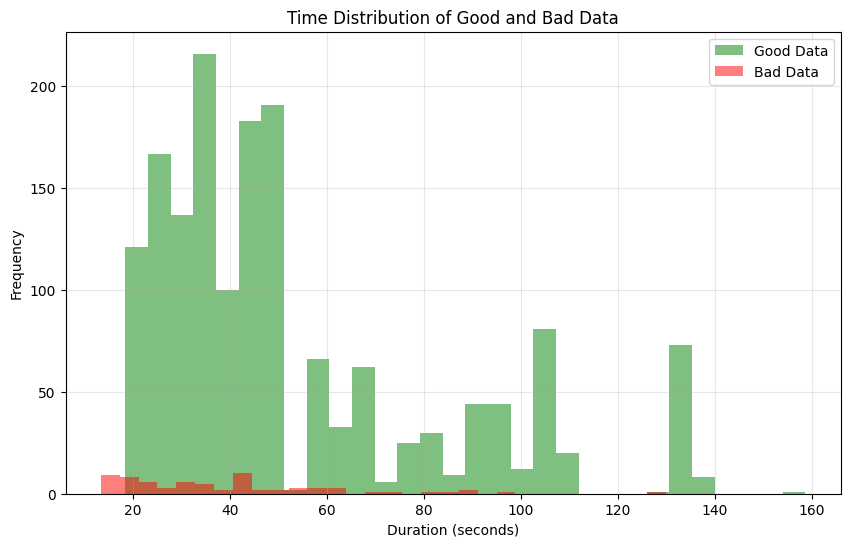

In [7]:
# Sampling frequency
sampling_rate = 2000  # 2 kHz (2000 samples per second)

# Separate good and bad data
good_indices = [i for i, label in enumerate(y_data) if label.endswith("_good")]
bad_indices = [i for i, label in enumerate(y_data) if label.endswith("_bad")]

good_X_data = [X_data[i] for i in good_indices]
bad_X_data = [X_data[i] for i in bad_indices]

# Calculate durations in seconds
good_durations = [len(sample) / sampling_rate for sample in good_X_data]
bad_durations = [len(sample) / sampling_rate for sample in bad_X_data]

# Compute min, max, and average durations
good_min_duration = min(good_durations) if good_durations else 0
good_max_duration = max(good_durations) if good_durations else 0
good_avg_duration = np.mean(good_durations) if good_durations else 0

bad_min_duration = min(bad_durations) if bad_durations else 0
bad_max_duration = max(bad_durations) if bad_durations else 0
bad_avg_duration = np.mean(bad_durations) if bad_durations else 0

# Print the results
print("\nDuration Range for Good Data (seconds):")
print(f"  Minimum: {good_min_duration:.2f} seconds")
print(f"  Maximum: {good_max_duration:.2f} seconds")
print(f"  Average: {good_avg_duration:.2f} seconds")

print("\nDuration Range for Bad Data (seconds):")
print(f"  Minimum: {bad_min_duration:.2f} seconds")
print(f"  Maximum: {bad_max_duration:.2f} seconds")
print(f"  Average: {bad_avg_duration:.2f} seconds")

# Plot the time distribution
plt.figure(figsize=(10, 6))
plt.hist(good_durations, bins=30, alpha=0.5, label='Good Data', color='green')
plt.hist(bad_durations, bins=30, alpha=0.5, label='Bad Data', color='red')
plt.title('Time Distribution of Good and Bad Data')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

It's evident that the dataset is imbalanced. With 1,632 instances of good data and 70 instances of bad data, the bar chart above illustrates the red areas representing the bad data and the green areas representing the good data. In this duration and frequency bar chart, it appears that most of the data points are below 50 seconds in length.

In the following seciton we further explored the differences between operation times in the following plot. The smallest operation duration was 13.4 seconds and the largest operation duration was 158.7 seconds. Since each operation duration is different, certain decisions need to be made about preprocessing and the architecture of the network.

One approach would be to choose a fixed window of time to break the data into. This methodology would be flexible for a wide range of networks. However, there are difficulties in choosing an appropriate window size that would capture the relationships of the good and bad results. The fixed window may also not generalize well in the case where an anomoly which exceeds tot window is encountered during operation.

Another approach would be to select a network architecture such as an RNN or LSTM which can handle streamed, sequential data and is not bound to a fixed window.

Further exploration into both approaches will be conducted in future milestones.

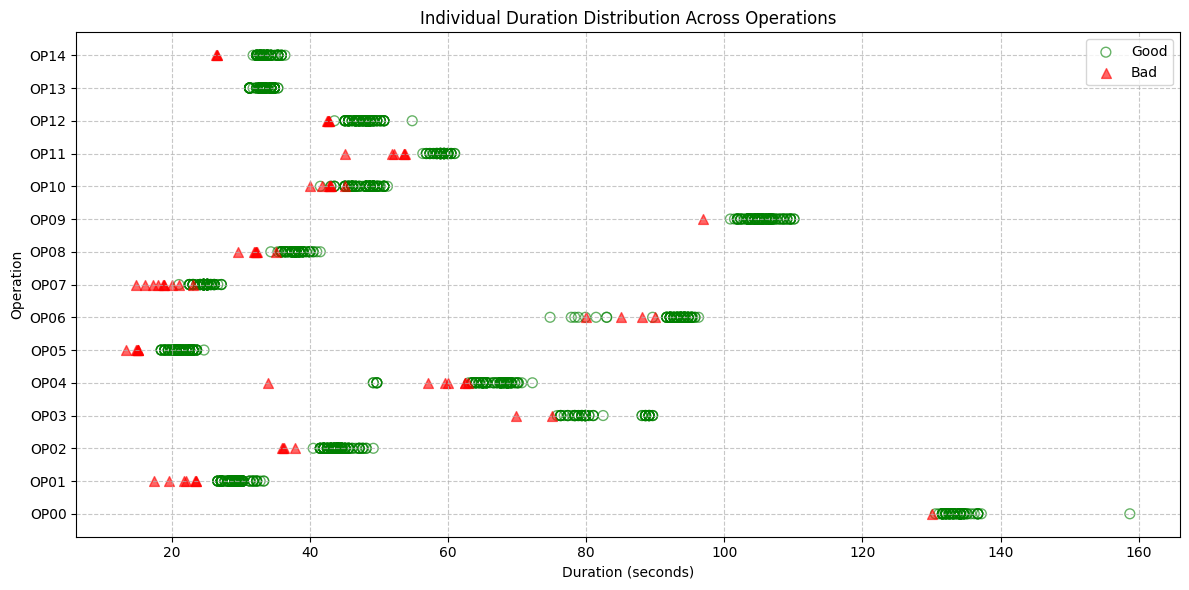


Time Range Between Different Operations (seconds):
OP00:
  Good - Min: 130.56, Max: 158.72, Avg: 133.90, Count: 83
  Bad  - Min: 130.00, Max: 130.00, Avg: 130.00, Count: 1
OP01:
  Good - Min: 26.62, Max: 33.28, Avg: 29.18, Count: 136
  Bad  - Min: 17.45, Max: 23.54, Avg: 21.55, Count: 7
OP02:
  Good - Min: 40.45, Max: 49.15, Avg: 43.90, Count: 148
  Bad  - Min: 35.86, Max: 37.87, Avg: 36.48, Count: 4
OP03:
  Good - Min: 75.78, Max: 89.60, Avg: 81.99, Count: 68
  Bad  - Min: 69.83, Max: 75.00, Avg: 72.41, Count: 2
OP04:
  Good - Min: 49.15, Max: 72.19, Avg: 65.92, Count: 105
  Bad  - Min: 33.87, Max: 62.88, Avg: 56.87, Count: 7
OP05:
  Good - Min: 18.43, Max: 24.62, Avg: 21.25, Count: 114
  Bad  - Min: 13.40, Max: 15.10, Avg: 14.71, Count: 6
OP06:
  Good - Min: 74.75, Max: 96.26, Avg: 92.24, Count: 84
  Bad  - Min: 80.00, Max: 90.00, Avg: 85.77, Count: 4
OP07:
  Good - Min: 20.99, Max: 27.14, Avg: 24.75, Count: 148
  Bad  - Min: 14.74, Max: 23.00, Avg: 18.64, Count: 10
OP08:
  Good - M

In [8]:
# New Section: Check Time Range Between Different Operations (Scatter Plot of Individual Durations)
import numpy as np
import matplotlib.pyplot as plt

# Sampling frequency (already defined, but included for clarity)
sampling_rate = 2000  # 2 kHz (2000 samples per second)

# Dictionary to store durations with good/bad distinction
operation_durations = {op: {'good': [], 'bad': []} for op in process_names}

# Calculate durations and group by operation and label
for i, (sample, label) in enumerate(zip(X_data, y_data)):
    # Extract operation name from the label (e.g., "M01_Aug_2019_OP00_000_good" -> "OP00")
    operation = None
    for op in process_names:
        if op in label:
            operation = op
            break
    if operation is None:
        continue  # Skip if operation not found in label

    # Determine if good or bad from label
    quality = 'good' if 'good' in label.lower() else 'bad'

    # Calculate duration in seconds
    duration = len(sample) / sampling_rate
    operation_durations[operation][quality].append(duration)

# Prepare data for plotting
plt.figure(figsize=(12, 6))

# Plot individual durations for each operation
y_positions = range(len(process_names))
for i, operation in enumerate(process_names):
    good_durations = operation_durations[operation]['good']
    bad_durations = operation_durations[operation]['bad']

    # Plot good durations as green empty circles
    if good_durations:
        plt.scatter(good_durations, [i] * len(good_durations),
                    facecolors='none', edgecolors='green', marker='o', s=50, alpha=0.6, label='Good' if i == 0 else None)

    # Plot bad durations as red triangles
    if bad_durations:
        plt.scatter(bad_durations, [i] * len(bad_durations),
                   color='red', marker='^', s=50, alpha=0.6, label='Bad' if i == 0 else None)

# Customize the plot
plt.yticks(y_positions, process_names)
plt.xlabel('Duration (seconds)')
plt.ylabel('Operation')
plt.title('Individual Duration Distribution Across Operations')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print summary statistics for reference
print("\nTime Range Between Different Operations (seconds):")
for operation in process_names:
    good_durs = operation_durations[operation]['good']
    bad_durs = operation_durations[operation]['bad']

    if not (good_durs or bad_durs):
        print(f"{operation}: No data available")
        continue

    print(f"{operation}:")
    if good_durs:
        print(f"  Good - Min: {min(good_durs):.2f}, Max: {max(good_durs):.2f}, Avg: {np.mean(good_durs):.2f}, Count: {len(good_durs)}")
    if bad_durs:
        print(f"  Bad  - Min: {min(bad_durs):.2f}, Max: {max(bad_durs):.2f}, Avg: {np.mean(bad_durs):.2f}, Count: {len(bad_durs)}")

The scatter plot highlights a notable outlier in OP00, with a good data point at 158 seconds, standing out against the majority of durations that cluster below 50 seconds across operations. A higher percentage of bad data points (red triangles) is evident below 50 seconds, particularly in operations like OP02, OP07, and OP08, where they densely cluster around 20–40 seconds. Smaller, transparent symbols help manage overlaps, revealing these patterns and suggesting potential inconsistencies in operations that warrant further investigation.

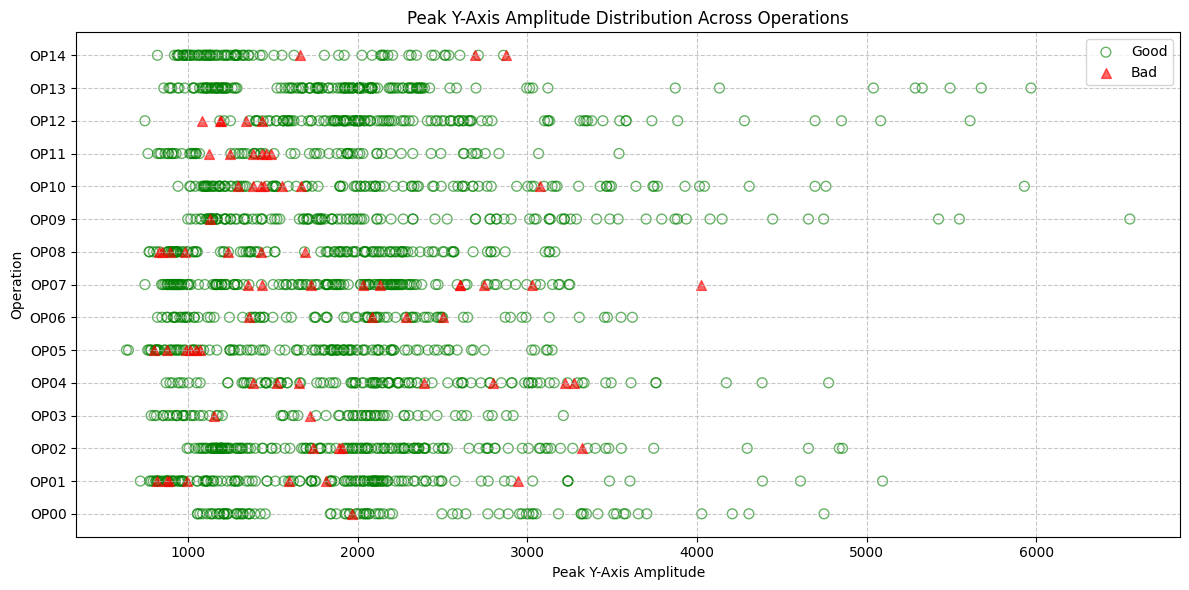


Peak Y-Axis Amplitude Across Different Operations:

Global Statistics:
  Good - Global Min: 636.00, Global Max: 6552.00
  Bad  - Global Min: 800.00, Global Max: 4026.00

Per Operation Statistics:
OP00:
  Good - Min: 1054.00, Max: 4749.00, Avg: 2185.48, Count: 83
  Bad  - Min: 1963.00, Max: 1963.00, Avg: 1963.00, Count: 1
OP01:
  Good - Min: 718.00, Max: 5094.00, Avg: 1773.55, Count: 136
  Bad  - Min: 817.00, Max: 2943.00, Avg: 1418.29, Count: 7
OP02:
  Good - Min: 993.00, Max: 4858.00, Avg: 2004.99, Count: 148
  Bad  - Min: 1735.00, Max: 3322.00, Avg: 2213.25, Count: 4
OP03:
  Good - Min: 782.00, Max: 3212.00, Avg: 1732.87, Count: 68
  Bad  - Min: 1151.00, Max: 1717.00, Avg: 1434.00, Count: 2
OP04:
  Good - Min: 870.00, Max: 4776.00, Avg: 2206.88, Count: 105
  Bad  - Min: 1385.00, Max: 3275.00, Avg: 2320.71, Count: 7
OP05:
  Good - Min: 636.00, Max: 3146.00, Avg: 1670.11, Count: 114
  Bad  - Min: 800.00, Max: 1069.00, Avg: 964.50, Count: 6
OP06:
  Good - Min: 819.00, Max: 3619.00, Avg

In [9]:
# New Section: Check Y-Axis Amplitude Across Different Operations (Scatter Plot of Peak Amplitudes)

# Dictionary to store peak Y-axis amplitudes with good/bad distinction
operation_amplitudes = {op: {'good': [], 'bad': []} for op in process_names}

# Lists to store all amplitudes for global max/min calculation
all_good_amplitudes = []
all_bad_amplitudes = []

# Calculate peak Y-axis amplitudes and group by operation and label
for i, (sample, label) in enumerate(zip(X_data, y_data)):
    # Extract operation name from the label (e.g., "M01_Aug_2019_OP00_000_good" -> "OP00")
    operation = None
    for op in process_names:
        if op in label:
            operation = op
            break
    if operation is None:
        continue  # Skip if operation not found in label

    # Determine if good or bad from label
    quality = 'good' if 'good' in label.lower() else 'bad'

    # Calculate the maximum absolute amplitude of the Y-axis (column 1)
    peak_amplitude = np.max(np.abs(sample[:, 1]))  # Y-axis is the second column (index 1)
    operation_amplitudes[operation][quality].append(peak_amplitude)

    # Store amplitudes for global max/min
    if quality == 'good':
        all_good_amplitudes.append(peak_amplitude)
    else:
        all_bad_amplitudes.append(peak_amplitude)

# Calculate global max and min
global_max_good = max(all_good_amplitudes) if all_good_amplitudes else None
global_min_good = min(all_good_amplitudes) if all_good_amplitudes else None
global_max_bad = max(all_bad_amplitudes) if all_bad_amplitudes else None
global_min_bad = min(all_bad_amplitudes) if all_bad_amplitudes else None

# Prepare data for plotting
plt.figure(figsize=(12, 6))

# Plot individual peak amplitudes for each operation
y_positions = range(len(process_names))
for i, operation in enumerate(process_names):
    good_amplitudes = operation_amplitudes[operation]['good']
    bad_amplitudes = operation_amplitudes[operation]['bad']

    # Plot good amplitudes as green empty circles
    if good_amplitudes:
        plt.scatter(good_amplitudes, [i] * len(good_amplitudes),
                    facecolors='none', edgecolors='green', marker='o', s=50, alpha=0.6, label='Good' if i == 0 else None)

    # Plot bad amplitudes as red triangles
    if bad_amplitudes:
        plt.scatter(bad_amplitudes, [i] * len(bad_amplitudes),
                    color='red', marker='^', s=50, alpha=0.6, label='Bad' if i == 0 else None)

# Customize the plot
plt.yticks(y_positions, process_names)
plt.xlabel('Peak Y-Axis Amplitude')
plt.ylabel('Operation')
plt.title('Peak Y-Axis Amplitude Distribution Across Operations')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print summary statistics for reference, including global max/min
print("\nPeak Y-Axis Amplitude Across Different Operations:")
print("\nGlobal Statistics:")
if all_good_amplitudes:
    print(f"  Good - Global Min: {global_min_good:.2f}, Global Max: {global_max_good:.2f}")
if all_bad_amplitudes:
    print(f"  Bad  - Global Min: {global_min_bad:.2f}, Global Max: {global_max_bad:.2f}")

print("\nPer Operation Statistics:")
for operation in process_names:
    good_amps = operation_amplitudes[operation]['good']
    bad_amps = operation_amplitudes[operation]['bad']

    if not (good_amps or bad_amps):
        print(f"{operation}: No data available")
        continue

    print(f"{operation}:")
    if good_amps:
        print(f"  Good - Min: {min(good_amps):.2f}, Max: {max(good_amps):.2f}, Avg: {np.mean(good_amps):.2f}, Count: {len(good_amps)}")
    if bad_amps:
        print(f"  Bad  - Min: {min(bad_amps):.2f}, Max: {max(bad_amps):.2f}, Avg: {np.mean(bad_amps):.2f}, Count: {len(bad_amps)}")

The scatter plot reveals a broad range of peak Y-axis amplitudes, from 636 to 6552, with bad samples (red triangles) frequently showing higher amplitudes, especially in operations like OP04 and OP07. Applying a logarithmic transformation compresses this range, aiming to make differences between good and bad samples more discernible, but no distinct patterns emerge to clearly differentiate them across operations. This suggests that further normalization or alternative preprocessing methods may be needed to better identify consistent features for distinguishing good and bad samples.

## Plot sample acceleration data


Total number of 'good' files: 1632
Total number of 'bad' files: 70
Total number of files: 1702
Plotting Good Sample 1 (Shape: (268288, 3)) - Label: M01_Aug_2019_OP00_000_good
Plotting Good Sample 2 (Shape: (49152, 3)) - Label: M02_Feb_2020_OP07_002_good
Plotting Good Sample 3 (Shape: (65536, 3)) - Label: M02_Feb_2021_OP14_014_good
Plotting Bad Sample 1 (Shape: (260000, 3)) - Label: M02_Feb_2021_OP00_000_bad
Plotting Bad Sample 2 (Shape: (34447, 3)) - Label: M02_Aug_2019_OP07_000_bad
Plotting Bad Sample 3 (Shape: (53041, 3)) - Label: M02_Feb_2019_OP14_001_bad


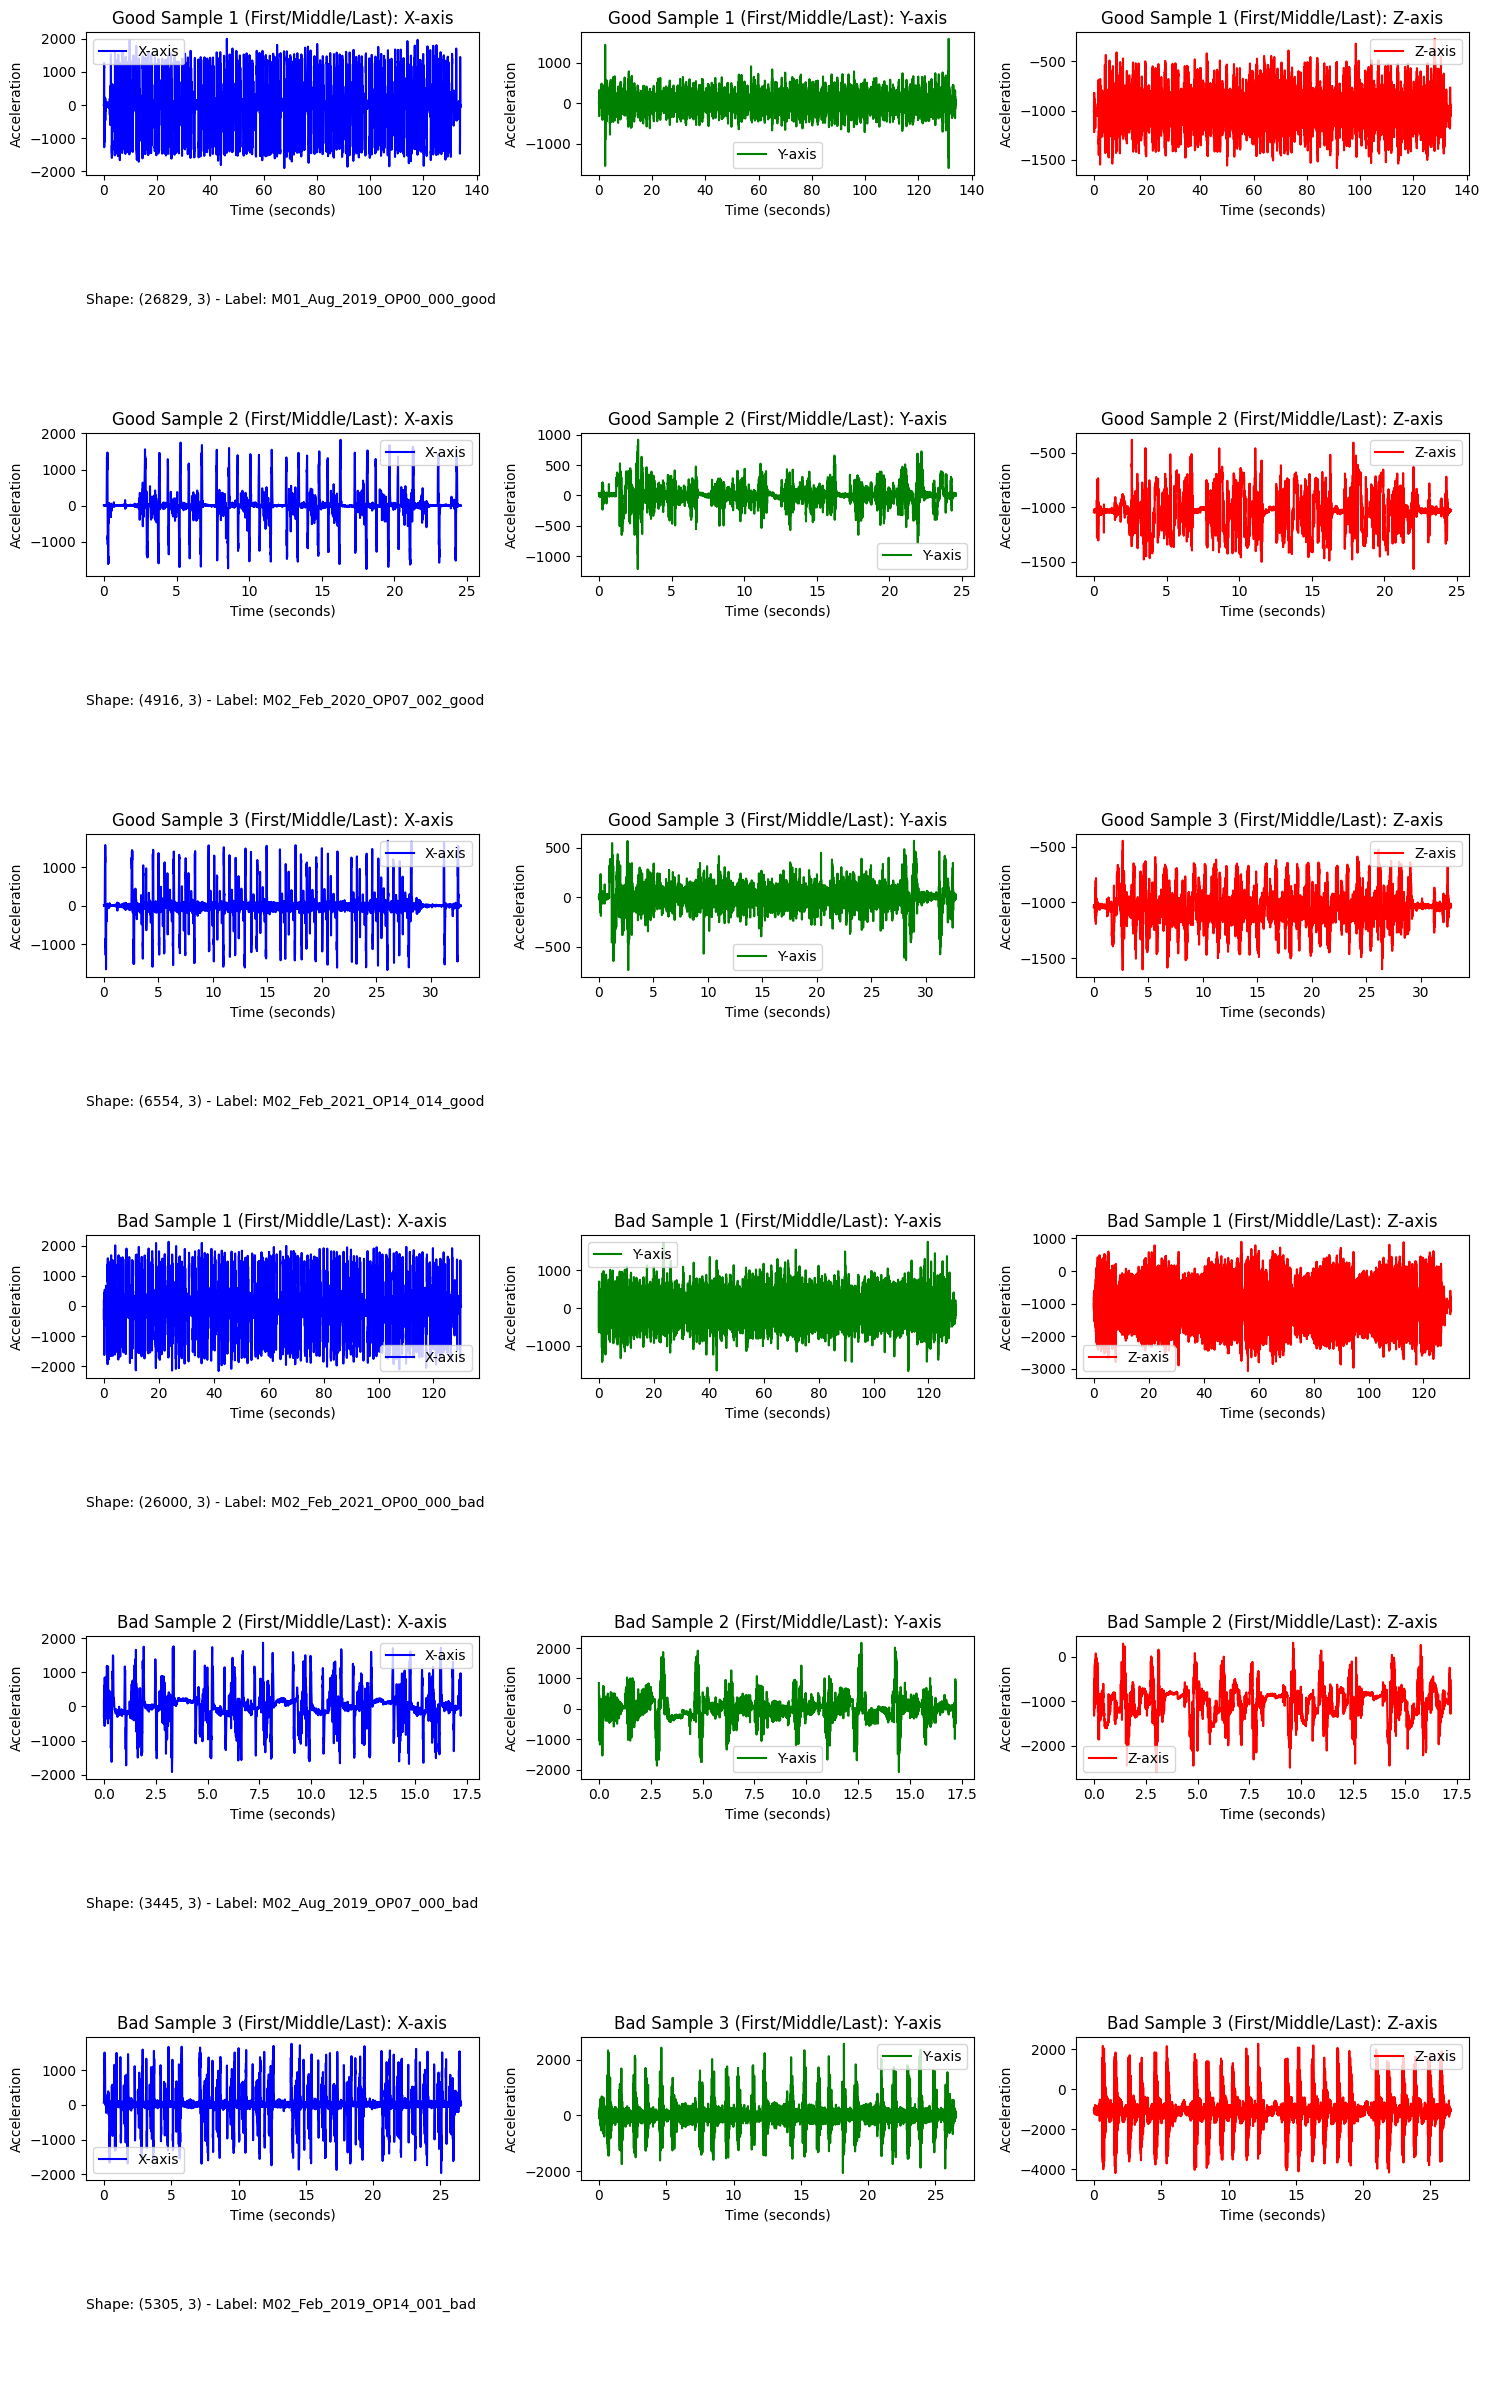

In [10]:
# Assuming X_data and y_data are already loaded from Part 1

# Part 2a: Calculate the number of "good" and "bad" files
good_indices = [i for i, label in enumerate(y_data) if label.endswith("_good")]
bad_indices = [i for i, label in enumerate(y_data) if label.endswith("_bad")]

good_file_count = len(good_indices)
bad_file_count = len(bad_indices)

print(f"\nTotal number of 'good' files: {good_file_count}")
print(f"Total number of 'bad' files: {bad_file_count}")
print(f"Total number of files: {good_file_count + bad_file_count}")

# Part 2b: Plot first, middle, and last "good" and "bad" files with x-axis in seconds

# Select first, middle, and last "good" and "bad" samples
good_X_data = [X_data[i] for i in good_indices]
bad_X_data = [X_data[i] for i in bad_indices]

# Calculate indices for first, middle, last
num_good = len(good_X_data)
num_bad = len(bad_X_data)

good_selected_indices = [
    0,  # First
    num_good // 2,  # Middle
    num_good - 1  # Last
]
bad_selected_indices = [
    0,  # First
    num_bad // 2,  # Middle
    num_bad - 1  # Last
]

good_samples = [good_X_data[i] for i in good_selected_indices]
good_labels = [y_data[good_indices[i]] for i in good_selected_indices]
bad_samples = [bad_X_data[i] for i in bad_selected_indices]
bad_labels = [y_data[bad_indices[i]] for i in bad_selected_indices]

# Sampling frequency
sampling_rate = 2000  # 2 kHz (2000 samples per second)

# Plotting: 3 good + 3 bad = 6 samples, 2 rows per sample (1 for plot, 1 for text)
total_samples = 3 * 2  # 3 good + 3 bad
fig, axes = plt.subplots(2 * total_samples, 3, figsize=(15, 4 * total_samples))

# Plot "good" samples
for i, (sample, label) in enumerate(zip(good_samples, good_labels)):
    print(f"Plotting Good Sample {i+1} (Shape: {sample.shape}) - Label: {label}")
    # Downsample for plotting if too large
    downsample_factor = 10
    if len(sample) > 10000:
        sample = sample[::downsample_factor, :]  # Take every 10th sample to reduce density

    # Create time array in seconds
    n_samples = len(sample)
    time_seconds = np.arange(n_samples) * (downsample_factor / sampling_rate)

    # X-axis
    axes[i*2, 0].plot(time_seconds, sample[:, 0], label='X-axis', color='blue')
    axes[i*2, 0].set_title(f"Good Sample {i+1} (First/Middle/Last): X-axis")
    axes[i*2, 0].set_ylabel('Acceleration')
    axes[i*2, 0].set_xlabel('Time (seconds)')
    axes[i*2, 0].legend()
    # Y-axis
    axes[i*2, 1].plot(time_seconds, sample[:, 1], label='Y-axis', color='green')
    axes[i*2, 1].set_title(f"Good Sample {i+1} (First/Middle/Last): Y-axis")
    axes[i*2, 1].set_ylabel('Acceleration')
    axes[i*2, 1].set_xlabel('Time (seconds)')
    axes[i*2, 1].legend()
    # Z-axis
    axes[i*2, 2].plot(time_seconds, sample[:, 2], label='Z-axis', color='red')
    axes[i*2, 2].set_title(f"Good Sample {i+1} (First/Middle/Last): Z-axis")
    axes[i*2, 2].set_ylabel('Acceleration')
    axes[i*2, 2].set_xlabel('Time (seconds)')
    axes[i*2, 2].legend()

    # Add shape and label info below the plot
    axes[i*2+1, 0].text(0, 0.5, f"Shape: {sample.shape} - Label: {label}", fontsize=10)
    axes[i*2+1, 0].axis('off')
    axes[i*2+1, 1].axis('off')
    axes[i*2+1, 2].axis('off')

# Plot "bad" samples
for i, (sample, label) in enumerate(zip(bad_samples, bad_labels)):
    print(f"Plotting Bad Sample {i+1} (Shape: {sample.shape}) - Label: {label}")
    row = (3 * 2) + i*2  # Offset for bad samples (starts at row 6)
    # Downsample for plotting if too large
    downsample_factor = 10
    if len(sample) > 10000:
        sample = sample[::downsample_factor, :]  # Take every 10th sample to reduce density

    # Create time array in seconds
    n_samples = len(sample)
    time_seconds = np.arange(n_samples) * (downsample_factor / sampling_rate)

    # X-axis
    axes[row, 0].plot(time_seconds, sample[:, 0], label='X-axis', color='blue')
    axes[row, 0].set_title(f"Bad Sample {i+1} (First/Middle/Last): X-axis")
    axes[row, 0].set_ylabel('Acceleration')
    axes[row, 0].set_xlabel('Time (seconds)')
    axes[row, 0].legend()
    # Y-axis
    axes[row, 1].plot(time_seconds, sample[:, 1], label='Y-axis', color='green')
    axes[row, 1].set_title(f"Bad Sample {i+1} (First/Middle/Last): Y-axis")
    axes[row, 1].set_ylabel('Acceleration')
    axes[row, 1].set_xlabel('Time (seconds)')
    axes[row, 1].legend()
    # Z-axis
    axes[row, 2].plot(time_seconds, sample[:, 2], label='Z-axis', color='red')
    axes[row, 2].set_title(f"Bad Sample {i+1} (First/Middle/Last): Z-axis")
    axes[row, 2].set_ylabel('Acceleration')
    axes[row, 2].set_xlabel('Time (seconds)')
    axes[row, 2].legend()

    # Add shape and label info below the plot
    axes[row+1, 0].text(0, 0.5, f"Shape: {sample.shape} - Label: {label}", fontsize=10)
    axes[row+1, 0].axis('off')
    axes[row+1, 1].axis('off')
    axes[row+1, 2].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

Plotting good and bad samples side by side in operation sequence reveals both differences and similarities, with bad samples often showing longer durations and more erratic acceleration patterns across X, Y, and Z axes. However, it remains difficult to confirm if these patterns are a reliable indicator or feature for distinguishing good versus bad samples across all operations. Additional analysis is needed to determine if extended durations and higher acceleration spikes consistently correlate with poor performance across various operations.

## Transform data to frequency domain

Plotting Good Data


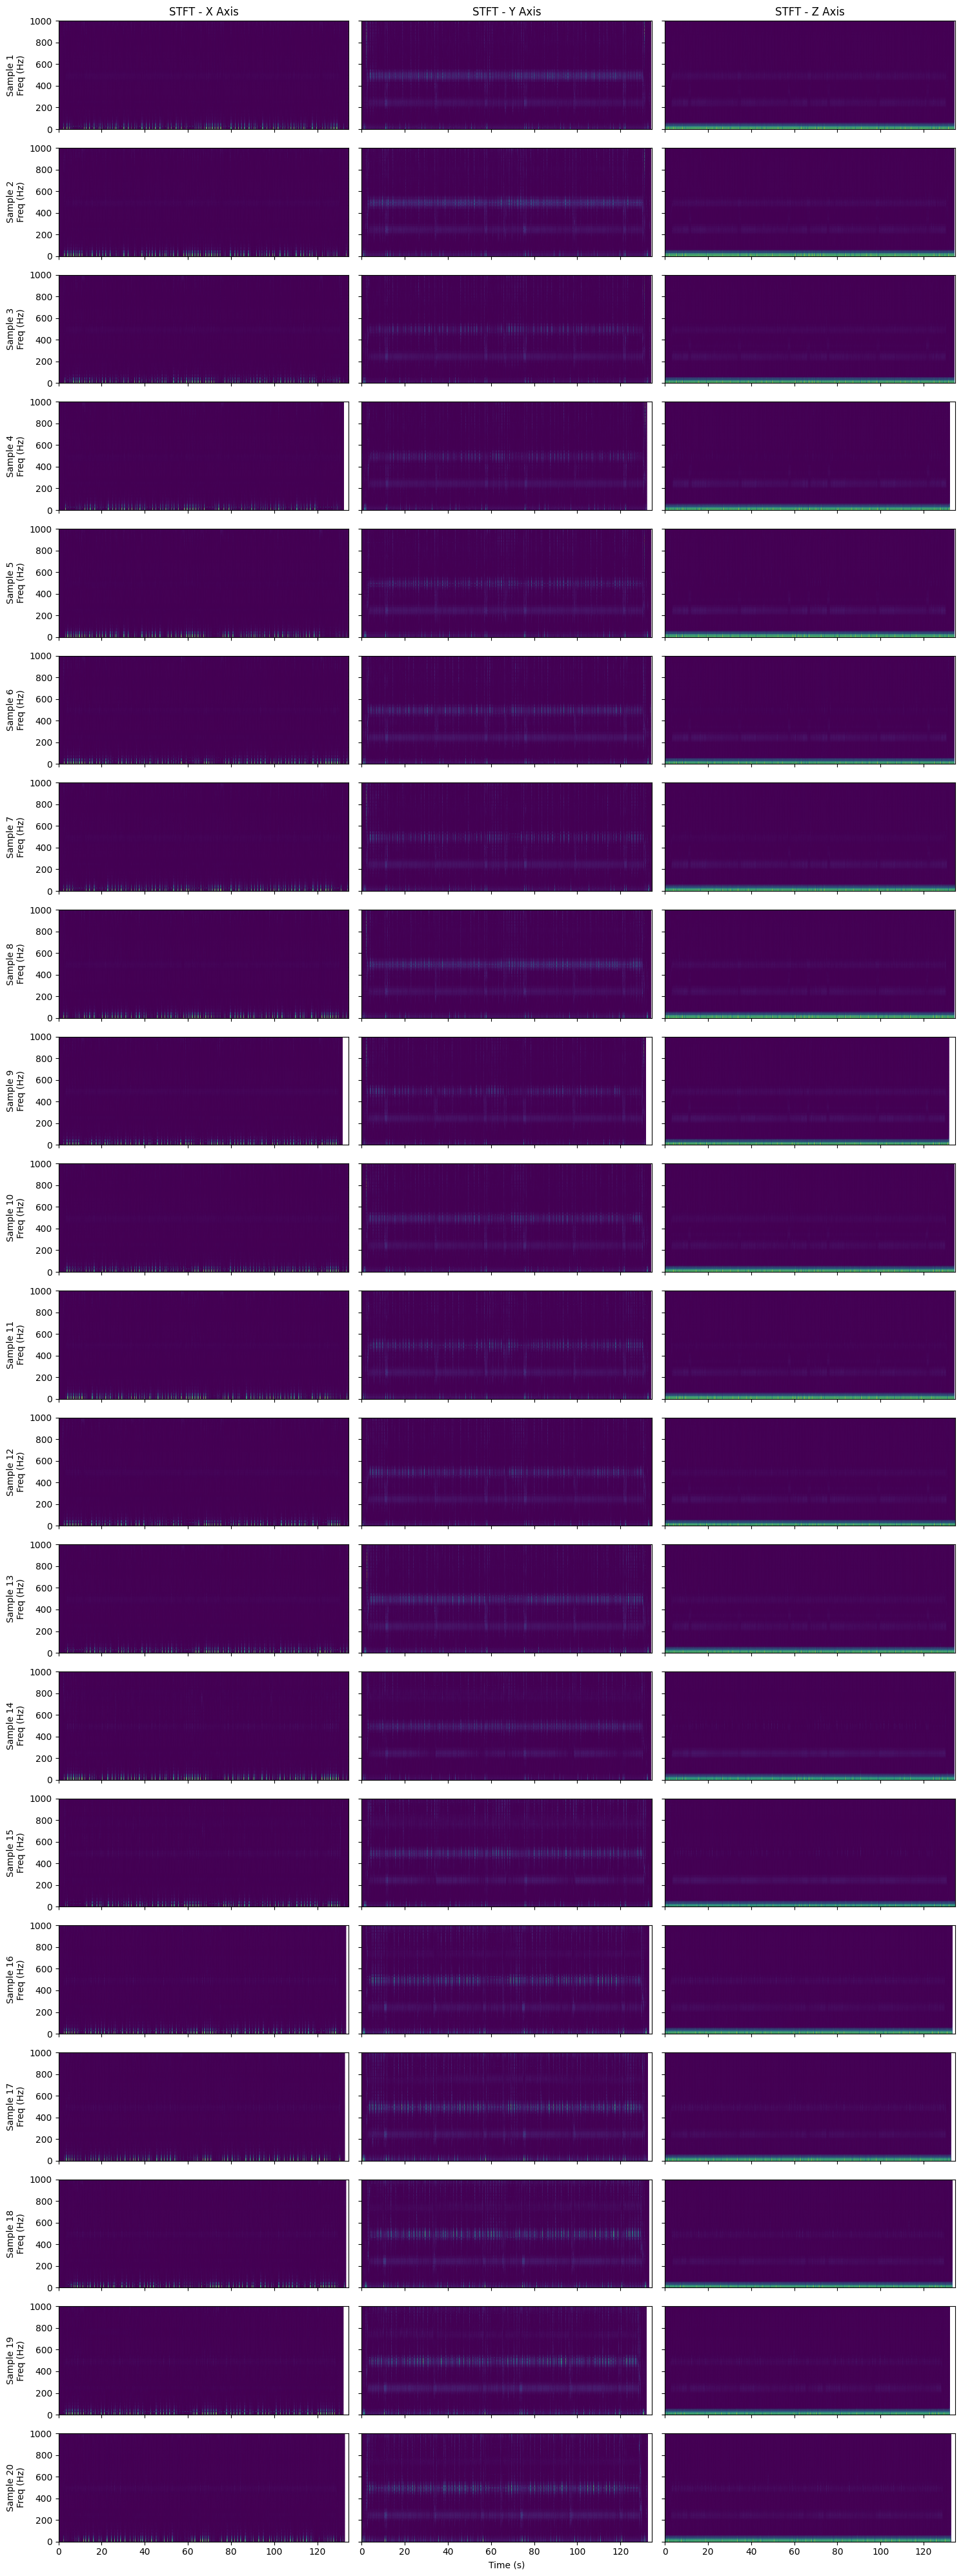

Plotting bad sample data


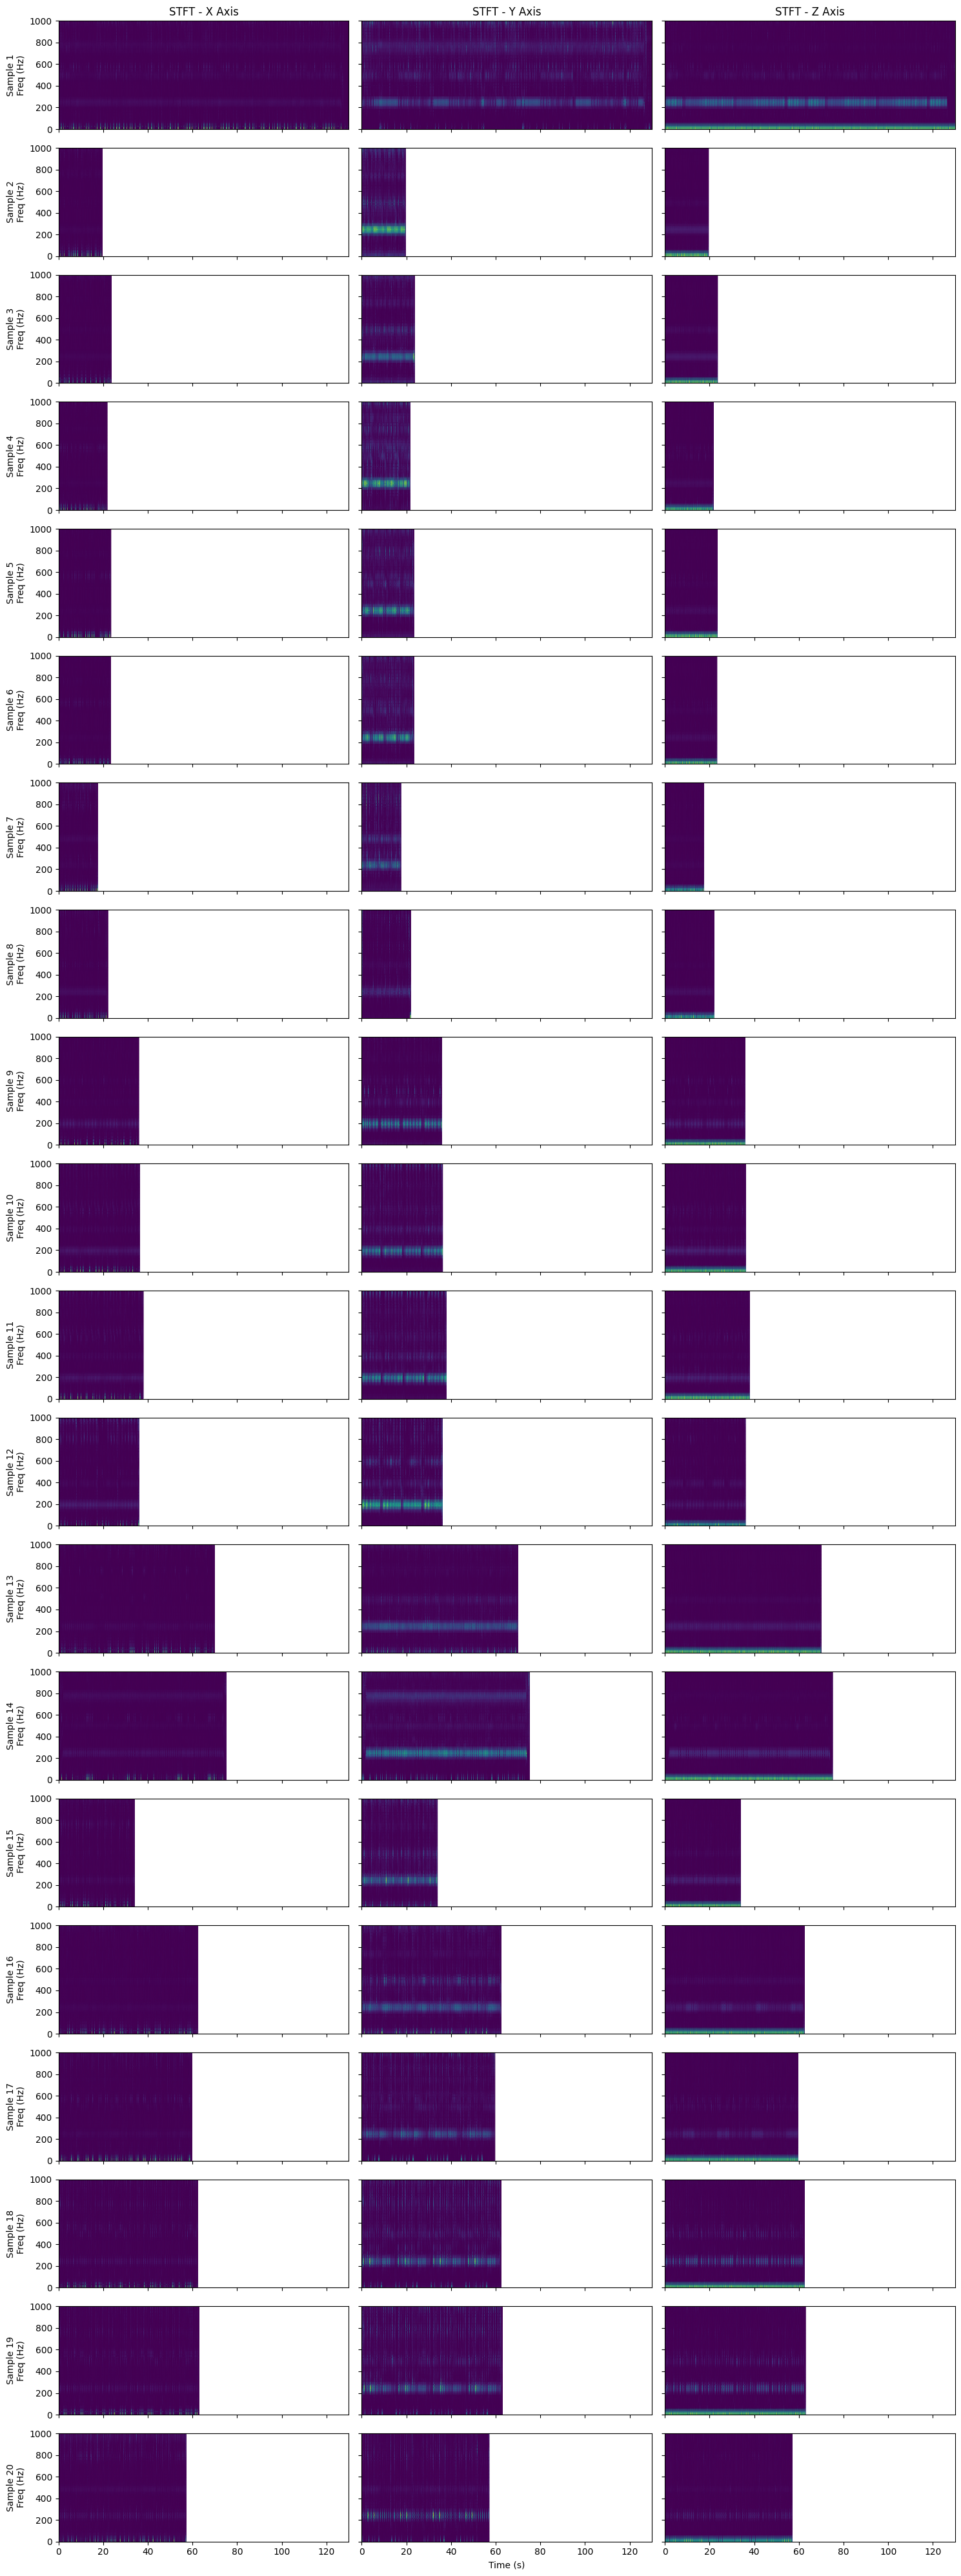

In [11]:
def plot_stft(data):

    fs = 2000
    window_size = 64
    noverlap = window_size // 2 # Overlapping for smoother view

    
    num_samples = 20  # Number of samples to repeat the plots
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 40), sharex=True, sharey=True)

    for sample_idx in range(num_samples):
        data_sample = data[sample_idx].T  # Transpose for X, Y, Z
        
        for i, (axis, label) in enumerate(zip(data_sample, ['X', 'Y', 'Z'])):
            f, t, Zxx = stft(axis, fs=fs, nperseg=window_size, noverlap=noverlap)
            
            # Plot Spectrogram
            ax = axes[sample_idx, i]
            ax.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
            ax.set_ylim(0, 1000)  # Limit to relevant frequencies
            
            if sample_idx == 0:  # Set titles only for the first row
                ax.set_title(f'STFT - {label} Axis')

            if i == 0:  # Set Y-label only for the first column
                ax.set_ylabel(f'Sample {sample_idx + 1}\nFreq (Hz)')
    
    axes[-1, 1].set_xlabel('Time (s)')  # Set x-label only at the bottom center
    plt.tight_layout()
    plt.show()




print ("Plotting Good Data")
plot_stft(good_X_data)


print("Plotting bad sample data")
plot_stft(bad_X_data)

## Chunking data approach

One approach to solving the issue of varying operation durations is to chunk the data into fixed windows of time.

In [12]:
X_data[0]

array([[   -9.,     9., -1011.],
       [  -21.,    19., -1011.],
       [  -15.,    23., -1020.],
       ...,
       [  -13.,    33., -1015.],
       [  -13.,    27., -1016.],
       [  -31.,    25., -1020.]])

In [13]:
def chunk_time_series(X_data, y_data):
    """
    Process time series data with memory efficiency by:
    1. Calculating the most common length (with tie-breaker)
    2. Processing each series individually
    3. Using numpy views instead of copies where possible
    """
    # Find chunk size using smallest mode of lengths
    lengths = [len(ts) for ts in X_data]
    counts = Counter(lengths)
    max_count = max(counts.values(), default=0)
    mode_candidates = [l for l, cnt in counts.items() if cnt == max_count]
    chunk_size = min(mode_candidates) if mode_candidates else 0

    # Pre-allocate lists to store results (avoids incremental resizing)
    chunked_data = []
    chunked_labels = []

    for ts, lbl in zip(X_data, y_data):
        ts_len = ts.shape[0]  # Use shape[0] for 2D array length

        # Process based on length comparison to chunk_size
        if ts_len < chunk_size:
            # Symmetric padding with minimal memory
            pad_total = chunk_size - ts_len
            pad_left = pad_total // 2
            pad_right = pad_total - pad_left
            
            # Create padded array with optimized numpy operations
            padded = np.zeros((chunk_size, ts.shape[1]), dtype=ts.dtype)
            padded[pad_left:pad_left+ts_len] = ts
            chunked_data.append(padded)
            chunked_labels.append(lbl)
            
        elif ts_len == chunk_size:
            # Use original array view (no copy)
            chunked_data.append(ts)
            chunked_labels.append(lbl)
            
        else:
            # Generate overlapping chunks without full copy
            num_chunks = int(np.ceil(ts_len / chunk_size))
            starts = np.linspace(0, ts_len - chunk_size, num=num_chunks, dtype=int)
            
            # Create memory-efficient views
            for start in starts:
                chunk = ts[start:start+chunk_size]
                chunked_data.append(chunk)
                chunked_labels.append(lbl)

    return chunked_data, chunked_labels

In [14]:
chunked_data, chunked_labels = chunk_time_series(X_data,y_data)

In [15]:
len(chunked_data), len(chunked_labels)

(3582, 3582)


Duration Range for Good Data (seconds):
  Minimum: 32.77 seconds
  Maximum: 32.77 seconds
  Average: 32.77 seconds

Duration Range for Bad Data (seconds):
  Minimum: 32.77 seconds
  Maximum: 32.77 seconds
  Average: 32.77 seconds


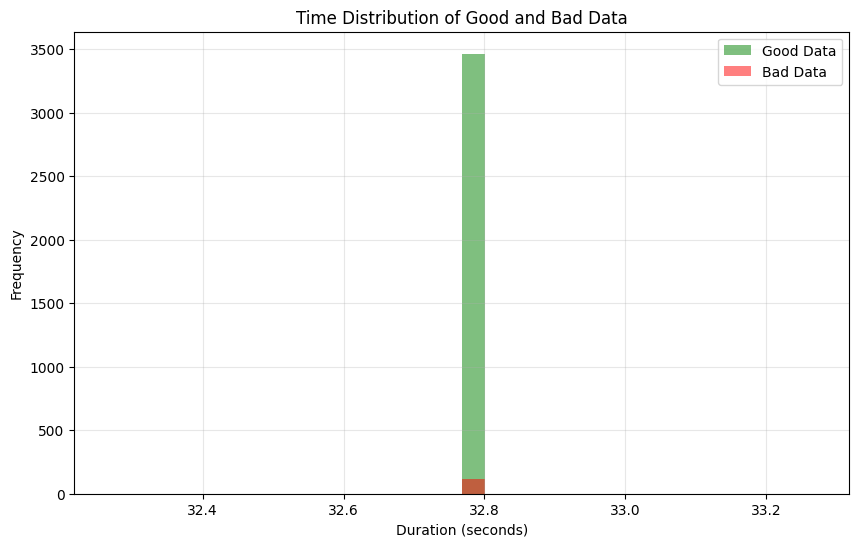

In [16]:
sampling_rate = 2000  # 2 kHz (2000 samples per second)

# Separate good and bad data
good_indices = [i for i, label in enumerate(chunked_labels) if label.endswith("_good")]
bad_indices = [i for i, label in enumerate(chunked_labels) if label.endswith("_bad")]

good_X_data = [chunked_data[i] for i in good_indices]
bad_X_data = [chunked_data[i] for i in bad_indices]

# Calculate durations in seconds
good_durations = [len(sample) / sampling_rate for sample in good_X_data]
bad_durations = [len(sample) / sampling_rate for sample in bad_X_data]

# Compute min, max, and average durations
good_min_duration = min(good_durations) if good_durations else 0
good_max_duration = max(good_durations) if good_durations else 0
good_avg_duration = np.mean(good_durations) if good_durations else 0

bad_min_duration = min(bad_durations) if bad_durations else 0
bad_max_duration = max(bad_durations) if bad_durations else 0
bad_avg_duration = np.mean(bad_durations) if bad_durations else 0

# Print the results
print("\nDuration Range for Good Data (seconds):")
print(f"  Minimum: {good_min_duration:.2f} seconds")
print(f"  Maximum: {good_max_duration:.2f} seconds")
print(f"  Average: {good_avg_duration:.2f} seconds")

print("\nDuration Range for Bad Data (seconds):")
print(f"  Minimum: {bad_min_duration:.2f} seconds")
print(f"  Maximum: {bad_max_duration:.2f} seconds")
print(f"  Average: {bad_avg_duration:.2f} seconds")

# Plot the time distribution
plt.figure(figsize=(10, 6))
plt.hist(good_durations, bins=30, alpha=0.5, label='Good Data', color='green')
plt.hist(bad_durations, bins=30, alpha=0.5, label='Bad Data', color='red')
plt.title('Time Distribution of Good and Bad Data')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
len(good_indices), len(bad_indices)

(3465, 117)